In [1]:
from facenet_pytorch import MTCNN
from PIL import Image
import torch
from imutils.video import FileVideoStream
import cv2
import time
import glob
from tqdm.notebook import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
filenames = ["get_together.jpg","graduation.jpg"]

In [5]:
class FastMTCNN(object):
    """Fast MTCNN implementation."""
    
    def __init__(self, stride, resize=1, *args, **kwargs):
        """Constructor for FastMTCNN class.
        
        Arguments:
            stride (int): The detection stride. Faces will be detected every `stride` frames
                and remembered for `stride-1` frames.
        
        Keyword arguments:
            resize (float): Fractional frame scaling. [default: {1}]
            *args: Arguments to pass to the MTCNN constructor. See help(MTCNN).
            **kwargs: Keyword arguments to pass to the MTCNN constructor. See help(MTCNN).
        """
        self.stride = stride
        self.resize = resize
        self.mtcnn = MTCNN(*args, **kwargs)
        
    def __call__(self, frames):
        """Detect faces in frames using strided MTCNN."""
        if self.resize != 1:
            frames = [
                cv2.resize(f, (int(f.shape[1] * self.resize), int(f.shape[0] * self.resize)))
                    for f in frames
            ]
                      
        boxes, probs = self.mtcnn.detect(frames[::self.stride])

        faces = []
        for i, frame in enumerate(frames):
            box_ind = int(i / self.stride)
            if boxes[box_ind] is None:
                continue
            for box in boxes[box_ind]:
                box = [int(b) for b in box]
                faces.append(frame[box[1]:box[3], box[0]:box[2]])
        
        return faces

In [6]:
# define our extractor
fast_mtcnn = FastMTCNN(
stride=4,
resize=0.5,
margin=14,
factor=0.6,
keep_all=True,
device=device
)

In [16]:
def run_detection(fast_mtcnn, filenames):
    frames = []
    all_faces = []
    frames_processed = 0
    faces_detected = 0
    batch_size = 60
    start = time.time()

    for filename in tqdm(filenames):

        v_cap = FileVideoStream(filename).start()
        v_len = int(v_cap.stream.get(cv2.CAP_PROP_FRAME_COUNT))

        for j in range(v_len):

            frame = v_cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

            if len(frames) >= batch_size or j == v_len - 1:

                faces = fast_mtcnn(frames)
                all_faces.extend(faces)

                frames_processed += len(frames)
                faces_detected += len(faces)
                frames = []

                print(
                    f'Frames per second: {frames_processed / (time.time() - start):.3f},',
                    f'faces detected: {faces_detected}\r',
                    end=''
                )

        v_cap.stop()
    return all_faces

In [18]:
all_faces = run_detection(fast_mtcnn, filenames)

Frames per second: 6.247, faces detected: 21


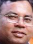

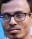

In [26]:
from torchvision import transforms
for face in all_faces:
    img = transforms.ToPILImage()(face).convert("RGB")
    display(img)

Reference:

[1] https://github.com/timesler/facenet-pytorch/blob/master/examples/face_tracking.ipynb